# Import Needed Libraries 

In [100]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout, BatchNormalization
from tensorflow.keras.applications import EfficientNetB0,EfficientNetB1,EfficientNetB2,EfficientNetB3,EfficientNetB4,EfficientNetB5
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

# Create Data Frame from Dataset

In [2]:
data_path = "/kaggle/input/brain-tumor-mri-images-44c"
folds = os.listdir(data_path)
data_paths = []
labels = []
for fold in folds:
    folderPath = os.path.join(data_path,fold)
    files = os.listdir(folderPath)
    for file in files:
     data_paths.append(os.path.join(folderPath,file))
     labels.append(fold.split(' ')[0])
data_df = pd.DataFrame(data = {"file_paths": data_paths, "labels": labels})

# plot value counts for a column in a dataframe

In [3]:
def count_plot(x, title, xlabel, ylabel, width, length, order = None, rotation=True, palette='summer'):
    plt.figure(figsize=(width,length))
    sns.countplot(x = x, palette=palette, order = order)
    plt.title(title, fontsize=25)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.show()

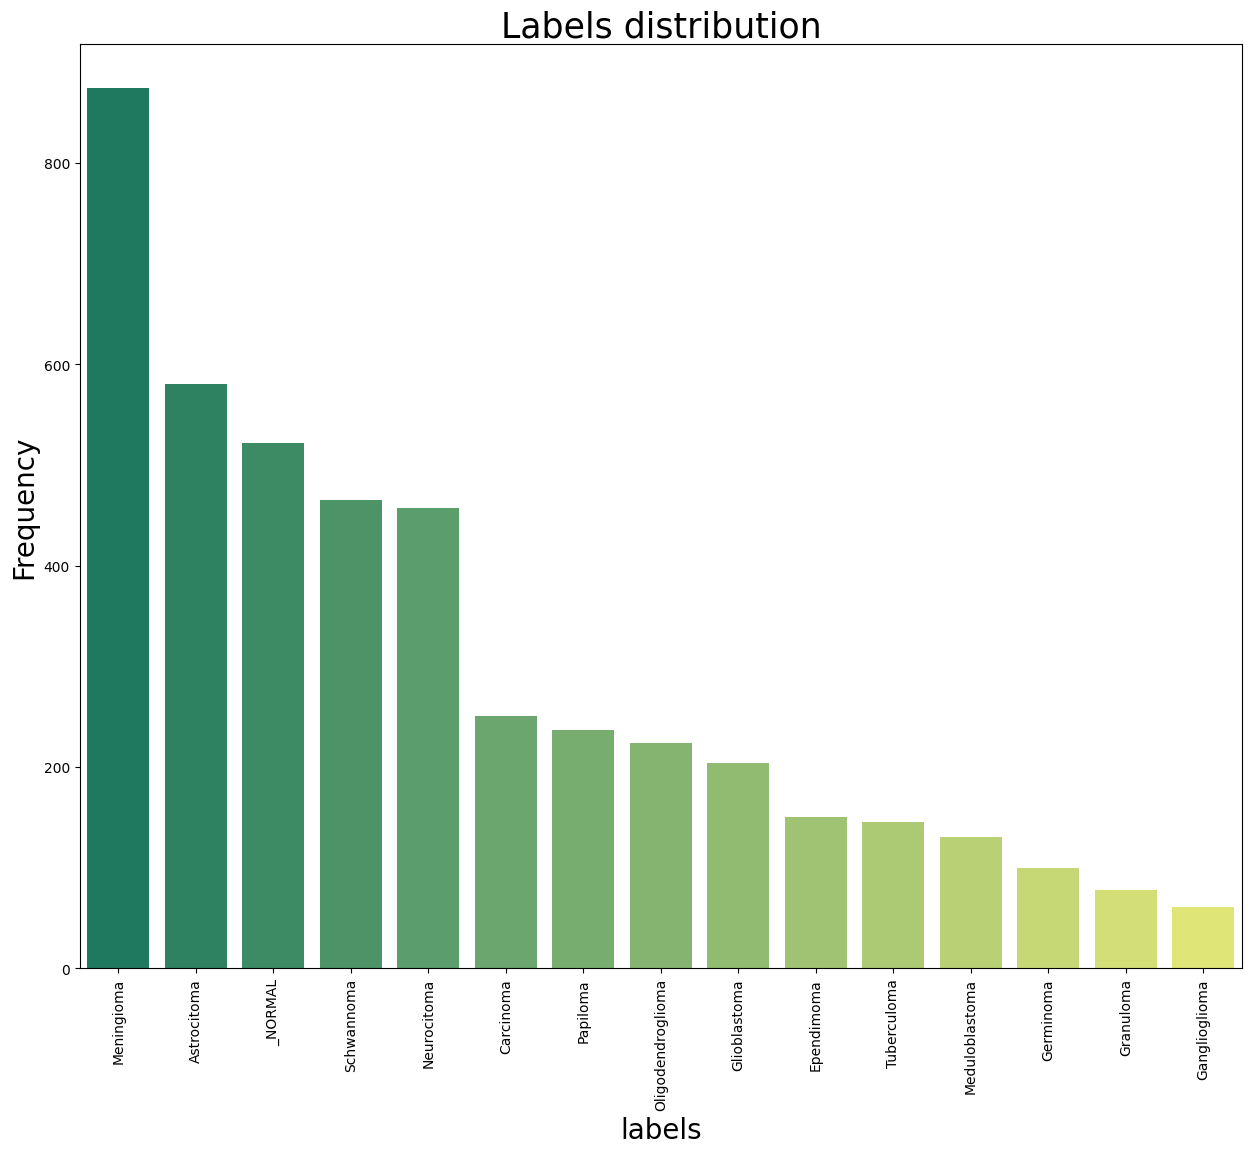

In [4]:
x = data_df['labels']
order = x.value_counts().index
count_plot(x, "Labels distribution", "labels", 'Frequency', 15,12, order=order)

# split data

In [5]:

def split_data(data_df, target_col='labels', train_size=0.8, valid_size=0.1, test_size=0.1, random_state=42):
    tr_df, dummy = train_test_split(
        data_df, 
        train_size=train_size, 
        random_state=random_state, 
        stratify=data_df[target_col]
    )

    valid_df, test_df = train_test_split(
        dummy,
        train_size=valid_size / (valid_size + test_size),  
        random_state=random_state,
        stratify=dummy[target_col]
    )

    return tr_df, valid_df, test_df


In [6]:
tr_df, valid_df, test_df = split_data(data_df)

# create generators

In [7]:
def create_generators(tr_df, valid_df, test_df, 
                      x_col="file_paths", y_col="labels", 
                      target_size=(224, 224), batch_size=32):
    gen = ImageDataGenerator(horizontal_flip=True, fill_mode='nearest')
    tr_gen = gen.flow_from_dataframe(
        dataframe=tr_df,
        x_col=x_col,
        y_col=y_col,
        target_size=target_size,
        batch_size=batch_size,
        class_mode="categorical",
        color_mode="rgb",
        shuffle=True
    )

    valid_gen = gen.flow_from_dataframe(
        dataframe=valid_df,
        x_col=x_col,
        y_col=y_col,
        target_size=target_size,
        batch_size=batch_size,
        class_mode="categorical",
        color_mode="rgb",
        shuffle=True
    )
    test_gen = gen.flow_from_dataframe(
        dataframe=test_df,
        x_col=x_col,
        y_col=y_col,
        target_size=target_size,
        batch_size=batch_size,
        class_mode="categorical",
        color_mode="rgb",
        shuffle=False
    )

    return tr_gen, valid_gen, test_gen


In [8]:
tr_gen, valid_gen, test_gen = create_generators(tr_df, valid_df, test_df)


Found 3582 validated image filenames belonging to 15 classes.
Found 448 validated image filenames belonging to 15 classes.
Found 448 validated image filenames belonging to 15 classes.


# show samples

In [9]:
def show_batch_samples(generator, class_names=None, n=25):
    images, labels = next(generator)
    if class_names is None:
        class_names = list(generator.class_indices.keys())
    plt.figure(figsize=(10, 6))
    for i in range(n):
        plt.subplot(int(np.sqrt(n)), int(np.sqrt(n)), i + 1)
        image = images[i] / 255.0  
        plt.imshow(image)
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


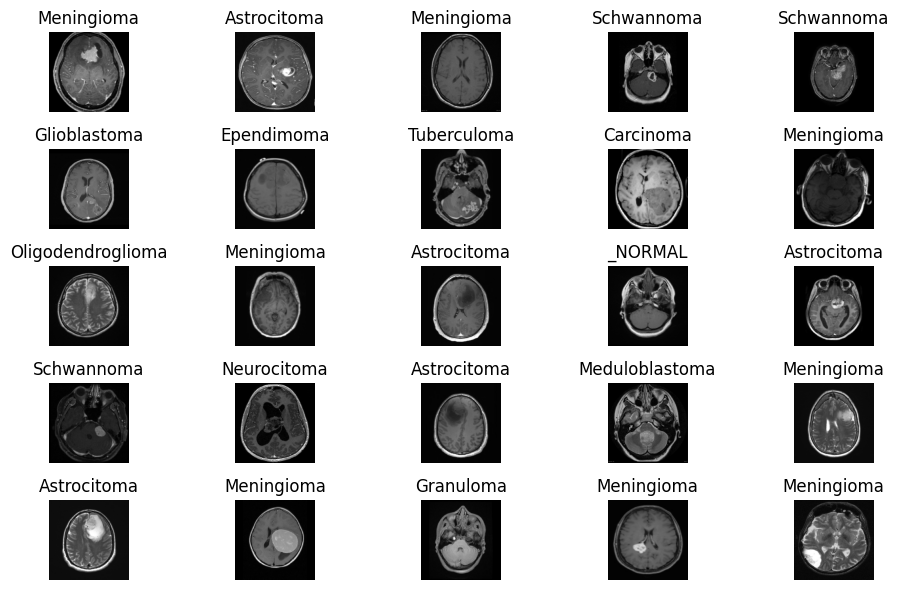

In [10]:
show_batch_samples(tr_gen)


# Callbacks

In [74]:
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras

class MyCallback(keras.callbacks.Callback):
    def __init__(self,patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        #self.my_model = model
        self.patience = patience 
        self.stop_patience = stop_patience 
        self.threshold = threshold 
        self.factor = factor 
        self.batches = batches 
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_permission = 1

        # callback variables
        self.count = 0 
        self.stop_count = 0
        self.best_epoch = 1  
        self.highest_tracc = 0.0 
        self.lowest_vloss = np.inf
        self.best_weights = None
        self.initial_weights = None
        self.initial_lr = None

    def on_train_begin(self, logs=None):
        self.initial_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        self.best_weights = self.model.get_weights()
        self.initial_weights = self.model.get_weights()
        self.model.optimizer.learning_rate.assign(self.initial_lr)

        msg = 'Do you want model to ask you to halt training manually [y/n]?'
        print(msg)
        ans = input('').strip().lower()
        if ans == 'y':
            self.ask_permission = 1
        else:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format(
            'Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration'
        )
        print(msg)
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration % 3600) // 60
        seconds = tr_duration % 60

        msg = f'Training finished in {int(hours)}h {int(minutes)}m {seconds:.2f}s'
        print(msg)

        # Restore best weights
        self.model.set_weights(self.best_weights)

    def on_train_batch_end(self, batch, logs=None):
        acc = logs.get('accuracy', 0) * 100
        loss = logs.get('loss', 0)
        msg = f'Processing batch {batch} of {self.batches} - Accuracy: {acc:.2f}% - Loss: {loss:.5f}'
        print(msg, '\r', end='')

    def on_epoch_begin(self, epoch, logs=None):
        self.ep_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        if self.count >= self.patience - 1:
            next_lr = lr * self.factor 
            self.model.optimizer.learning_rate.assign(next_lr)
            self.count = 0
            self.stop_count += 1
        else:
            next_lr = lr  
        if isinstance(self.model.optimizer, tf.keras.optimizers.Adam):  # Check if the optimizer is Adam
            self.model.optimizer.learning_rate.assign(next_lr)
            #tf.keras.backend.set_value(self.model.optimizer.learning_rate, next_lr)  # Update the learning rate
        else:
            print("Optimizer is not of type Adam.")

        acc = logs.get('accuracy')
        v_acc = logs.get('val_accuracy')
        loss = logs.get('loss')
        v_loss = logs.get('val_loss')

        monitor = ''
        pimprov = 0.0
        next_lr = lr

        if acc < self.threshold:
            monitor = 'accuracy'
            pimprov = 0.0 if epoch == 0 or self.highest_tracc == 0 else (acc - self.highest_tracc) * 100 / self.highest_tracc
            if acc > self.highest_tracc:
                self.highest_tracc = acc
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                self.best_epoch = epoch + 1
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
            else:
                if self.count >= self.patience - 1:
                    next_lr = lr * self.factor
                    self.model.optimizer.learning_rate.assign(next_lr)
                    #tf.keras.backend.set_value(self.model.optimizer.learning_rate, next_lr)
                    self.count = 0
                    self.stop_count += 1
                else:
                    self.count += 1
        else:
            monitor = 'val_loss'
            pimprov = 0.0 if epoch == 0 or self.lowest_vloss == np.inf else (self.lowest_vloss - v_loss) * 100 / self.lowest_vloss
            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                self.best_epoch = epoch + 1
            else:
                if self.count >= self.patience - 1:
                    next_lr = lr * self.factor
                    self.model.optimizer.learning_rate.assign(next_lr)
                    #tf.keras.backend.set_value(self.model.optimizer.learning_rate, next_lr)
                    self.count = 0
                    self.stop_count += 1
                else:
                    self.count += 1
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{epoch+1:^8}{loss:^10.3f}{acc*100:^9.2f}{v_loss:^9.3f}{v_acc*100:^9.2f}{lr:^9.5f}{next_lr:^9.5f}{monitor:^10}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count >= self.stop_patience:
            print(f'Training stopped at epoch {epoch+1} after {self.stop_patience} LR adjustments without improvement.')
            self.model.stop_training = True

        elif self.ask_epoch is not None and self.ask_permission and (epoch + 1) >= self.ask_epoch:
            print('Enter H to halt training or a number to continue training for that many more epochs:')
            ans = input('').strip()
            if ans.lower() == 'h':
                print(f'Training stopped manually at epoch {epoch + 1}')
                self.model.stop_training = True
            else:
                try:
                    more_epochs = int(ans)
                    self.ask_epoch += more_epochs
                    print(f'Training will continue to epoch {self.ask_epoch}')
                except:
                    print('Invalid input. Training will continue.')


# train data

In [84]:
def train_models(input_shape=(224, 224, 3), 
                              num_classes=15, 
                              train_gen=None, 
                              valid_gen=None, 
                              epochs=20):
    models_dict = {}
    efficientnet_models = {
    #"EfficientNetB0": EfficientNetB0,
    # "EfficientNetB1": EfficientNetB1,
    # "EfficientNetB2": EfficientNetB2,
    #"EfficientNetB3": EfficientNetB3,
    # "EfficientNetB4": EfficientNetB4,
    "EfficientNetB5": EfficientNetB5,
    }
    for name in efficientnet_models:
        print(f"\nTraining {name}...\n")
        base_model = efficientnet_models[name](
            include_top=False,
            weights='imagenet',
            input_shape=input_shape,
            pooling='max'
        )

        model = Sequential([
            base_model,
            Flatten(),
            BatchNormalization(axis=-1, momentum=0.99,epsilon= 0.001),
            Dense(256, activation='relu'),
            Dropout(rate= 0.45, seed= 123),
            Dense(num_classes, activation='softmax')
        ])
        initial_lr = 0.001
        #optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

        model.compile(optimizer=Adam(learning_rate=initial_lr),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        model.summary()
        batch_size = 32   
        epochs = 40   
        patience = 1  
        stop_patience = 3   
        threshold = 0.9  
        factor = 0.5   
        ask_epoch = 5   
        batches = int(np.ceil(len(train_gen.labels) / batch_size))    

        callbacks = [MyCallback(patience= patience, stop_patience= stop_patience,
                        threshold= threshold,factor= factor, batches= batches,
                        epochs= epochs, ask_epoch= ask_epoch )]
        history = model.fit(train_gen, validation_data=valid_gen, epochs=epochs, verbose=0,
                            callbacks=callbacks, validation_steps= None, shuffle= False)
        models_dict[name] = {
            "classifier": model,
            "model_history" : history
        }
        print('-' * 20)
    return models_dict


In [85]:
models_dict = train_models(train_gen=tr_gen,valid_gen=valid_gen)


Training EfficientNetB5...

115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb5 (Functional)          │ (None, 2048)                │      28,513,527 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_22 (Flatten)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,050,118 (110.82 MB)

 Trainable params: 28,873,279 (110.14 MB)

 Non-trainable params: 176,839 (690.78 KB)

Do you want model to ask you to halt training manually [y/n]?


 س


 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration


E0000 00:00:1745309521.306091      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745309521.496098      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745309521.875523      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745309522.070597      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745309522.558161      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

E0000 00:00:1745309638.593476      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745309638.784723      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745309639.160161      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745309639.355503      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745309639.845810      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

   1      2.084     49.94    8.165    50.45   0.00100  0.00100  accuracy    0.00    357.57 
   2      0.823     76.91    0.949    71.21   0.00050  0.00050  accuracy   54.00    44.00  
   3      0.322     89.78    0.572    81.47   0.00025  0.00025  accuracy   16.73    44.03  
   4      0.193     94.25    0.454    85.27   0.00013  0.00013  val_loss   20.66    44.25  
   5      0.115     96.54    0.308    90.40   0.00006  0.00006  val_loss   32.18    44.03  
   6      0.089     97.26    0.177    93.53   0.00003  0.00003  val_loss   42.66    44.01  
   7      0.071     98.27    0.113    96.88   0.00002  0.00002  val_loss   35.77    44.02  
   8      0.074     97.82    0.112    96.65   0.00001  0.00001  val_loss    0.79    44.05  
   9      0.080     97.65    0.099    97.10   0.00000  0.00000  val_loss   12.15    44.10  
   10     0.072     97.91    0.108    96.88   0.00000  0.00000  val_loss   -8.87    44.23  
   11     0.074     98.24    0.100    96.88   0.00000  0.00000  val_loss   -1.06

# test and evaluate models

In [86]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
for model_name, i in models_dict.items():
    model = i["classifier"]
    print(f"Evaluating model: {model_name}")
    train_score = model.evaluate(tr_gen, steps= test_steps, verbose= 1)
    valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
    test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])
    print('_' * 100)

Evaluating model: EfficientNetB5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 0.0101
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9778 - loss: 0.0707
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9683 - loss: 0.1179
Train Loss:  0.006902702152729034
Train Accuracy:  1.0
--------------------
Validation Loss:  0.07277540117502213
Validation Accuracy:  0.9732142686843872
--------------------
Test Loss:  0.07382144778966904
Test Accuracy:  0.9821428656578064
____________________________________________________________________________________________________


# plot loss and training of models

In [87]:
def plot_training(models_dict):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''
    for model_name, i in models_dict.items():
        hist = i["model_history"]
        print(f"Evaluating model: {model_name}")
    # Define needed variables
        tr_acc = hist.history['accuracy']
        tr_loss = hist.history['loss']
        val_acc = hist.history['val_accuracy']
        val_loss = hist.history['val_loss']
        index_loss = np.argmin(val_loss)
        val_lowest = val_loss[index_loss]
        index_acc = np.argmax(val_acc)
        acc_highest = val_acc[index_acc]
        Epochs = [i+1 for i in range(len(tr_acc))]
        loss_label = f'best epoch= {str(index_loss + 1)}'
        acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
        plt.figure(figsize= (20, 8))
        plt.style.use('fivethirtyeight')
        
        plt.subplot(1, 2, 1)
        plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
        plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
        plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
    
        plt.subplot(1, 2, 2)
        plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
        plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
        plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        print('_' * 50)
        plt.tight_layout
        plt.show()

In [ ]:
models_dict

Evaluating model: EfficientNetB5
__________________________________________________


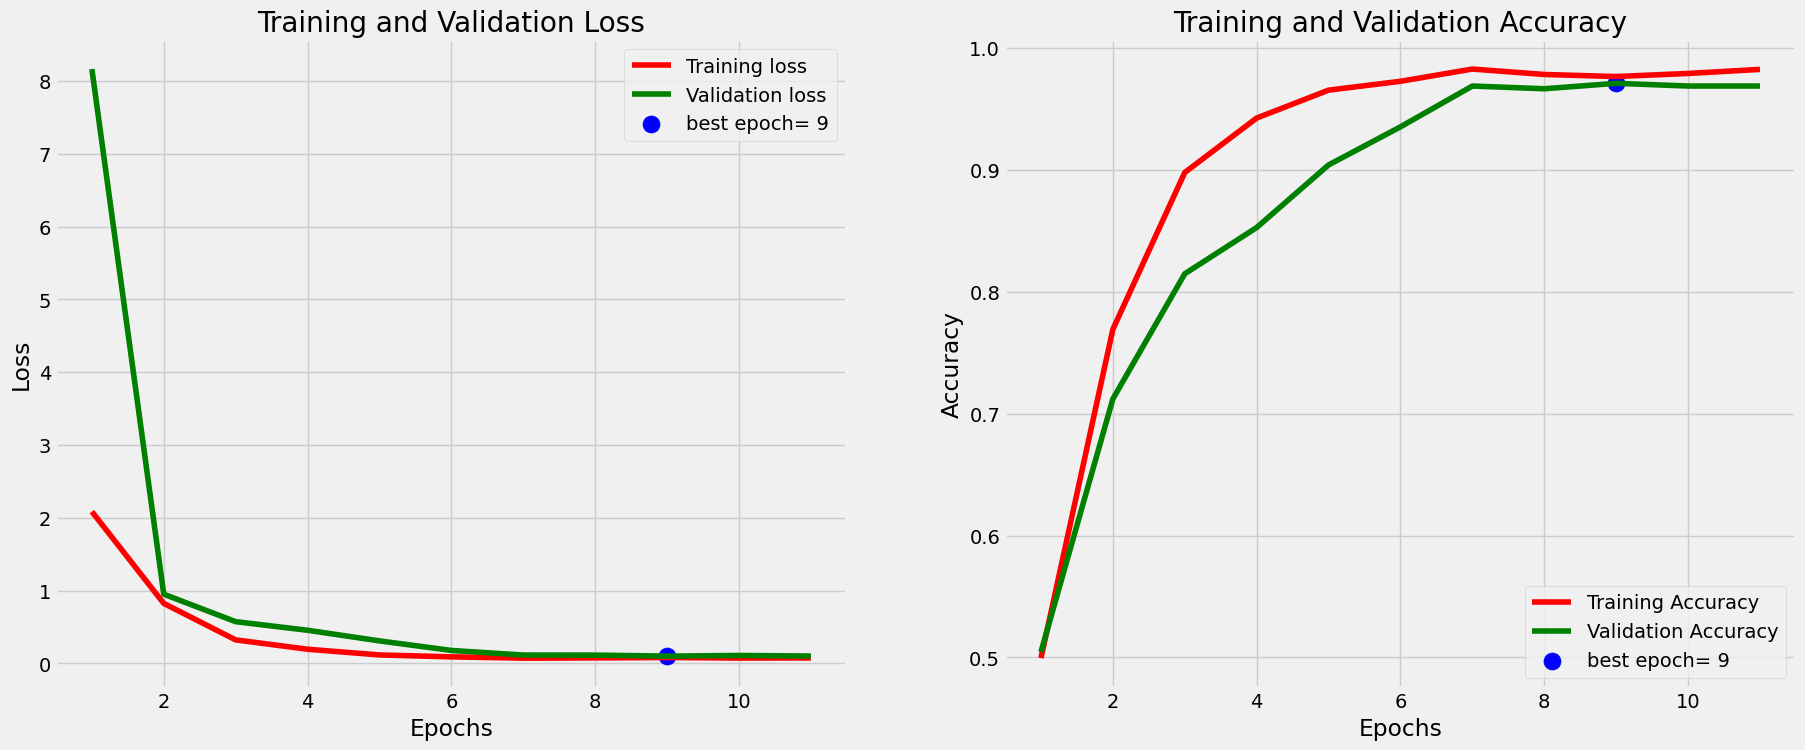

In [88]:
plot_training(models_dict)

# prediction of data

In [95]:
 for model_name, i in models_dict.items():
        print(f"Evaluating model: {model_name}")
        model = i["classifier"]
        i["y_pred"] = model.predict(test_gen)

# Convert the predicted probabilities to class labels
        i["y_pred_labels"] = np.argmax(i["y_pred"], axis=1)

# Get the true class labels from the test data generator
        i["y_true_labels"] = test_gen.classes

Evaluating model: EfficientNetB5
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step


# plot confusion matrix

Evaluating model: EfficientNetB5


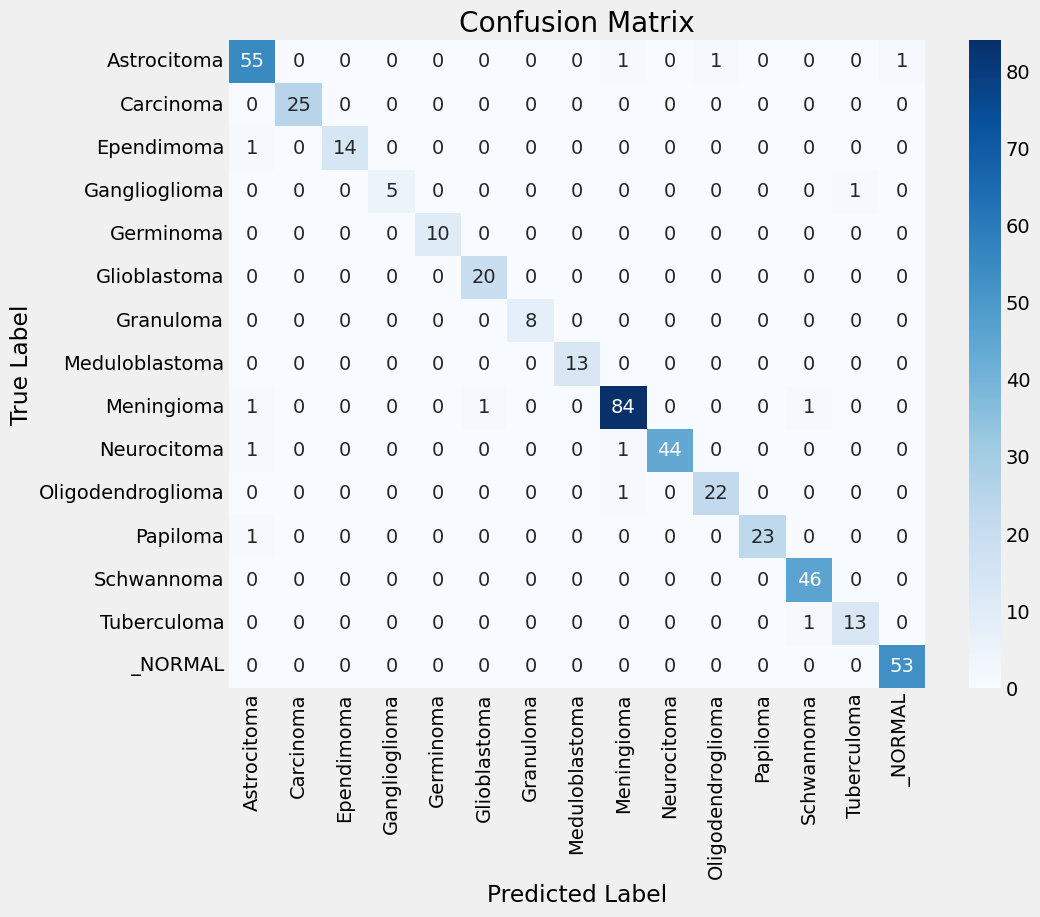

In [93]:
class_names = list(test_gen.class_indices.keys())
for model_name, i in models_dict.items():
        print(f"Evaluating model: {model_name}")
        model = i["classifier"]
        
        # Compute the confusion matrix
        confusion_mtx = confusion_matrix(i["y_true_labels"], i["y_pred_labels"])
        
        # Plot the confusion matrix using Seaborn heatmap
        plt.figure(figsize=(10,8))
        sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()


# plot classification report

In [96]:
for model_name, i in models_dict.items():
    print(f"Evaluating model: {model_name}")
    report = classification_report(i["y_true_labels"], i["y_pred_labels"], target_names=class_names)
    print("Classification Report: ")
    print(report)
    print('_' * 50)

Evaluating model: EfficientNetB5
Classification Report: 
                   precision    recall  f1-score   support

      Astrocitoma       0.93      0.97      0.95        58
        Carcinoma       1.00      1.00      1.00        25
       Ependimoma       1.00      0.93      0.97        15
    Ganglioglioma       1.00      0.83      0.91         6
        Germinoma       1.00      1.00      1.00        10
     Glioblastoma       1.00      1.00      1.00        20
        Granuloma       1.00      1.00      1.00         8
   Meduloblastoma       1.00      1.00      1.00        13
       Meningioma       0.98      0.99      0.98        87
      Neurocitoma       1.00      0.96      0.98        46
Oligodendroglioma       0.96      0.96      0.96        23
         Papiloma       1.00      0.96      0.98        24
       Schwannoma       0.98      1.00      0.99        46
      Tuberculoma       0.93      0.93      0.93        14
          _NORMAL       0.98      1.00      0.99        5

# save the best model

In [98]:
for model_name, i in models_dict.items():
    model_name = model_name
    subject = 'Brain Tumor'
    print(test_score[1])
    acc = test_score[1] * 100
    save_path = ''
    
    # Save model
    save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
    model_save_loc = os.path.join(save_path, save_id)
    model.save(model_save_loc)
    print(f'model was saved as {model_save_loc}')
    
    # Save weights
    weight_save_id = str(f'{model_name}-{subject}-.weights.h5')
    weights_save_loc = os.path.join(save_path, weight_save_id)
    model.save_weights(weights_save_loc)
    print(f'weights were saved as {weights_save_loc}')

0.9821428656578064
model was saved as EfficientNetB5-Brain Tumor-98.21.h5
weights were saved as EfficientNetB5-Brain Tumor-.weights.h5


# Load the model

In [101]:
model = load_model("EfficientNetB5-Brain Tumor-98.21.h5")
print(f'Model loaded from {"EfficientNetB5-Brain Tumor-98.21.h5"}')

model.load_weights("EfficientNetB5-Brain Tumor-.weights.h5")
print(f'Weights loaded from {"EfficientNetB5-Brain Tumor-.weights.h5"}')

Model loaded from EfficientNetB5-Brain Tumor-98.21.h5
Weights loaded from EfficientNetB5-Brain Tumor-.weights.h5


In [102]:
pip install kaggle


Note: you may need to restart the kernel to use updated packages.


In [108]:
!kaggle kernels output /kaggle/working/EfficientNetB5-Brain Tumor-.weights.h5 -p "D:\New folder"


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 433, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
